### 5. 実装コード

### 5.1 最終的に使用した実装コード

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error
import pandas as pd
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
import seaborn as sns

df_train = pd.read_csv('data/train.csv', encoding='utf-8')
df_train_add = pd.read_csv('data/train_add.csv', encoding='utf-8')
df_studium = pd.read_csv('data/stadium.csv', encoding='utf-8')
df_condition = pd.read_csv('data/condition.csv', encoding='utf-8')
df_condition_add = pd.read_csv('data/condition_add.csv', encoding='utf-8')

# add_dataの統合
df_train_concat = pd.concat([df_train, df_train_add])
df_condition_concat =  pd.concat([df_condition, df_condition_add])

#trainとconditionをmerge
df = pd.merge(df_train_concat, df_condition_concat, on="id")

#更にスタジアムをマージ
df = pd.merge(df, df_studium, left_on="stadium", right_on='name')

df.head()

,id,y,year,stage,match,gameday,time,home,away,stadium,...,away_05,away_06,away_07,away_08,away_09,away_10,away_11,name,address,capa
0,13994,18250,2012,Ｊ１,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,...,アレックス,青木 剛,増田 誓志,小笠原 満男,本山 雅志,大迫 勇也,ジュニーニョ,ユアテックスタジアム仙台,宮城県仙台市泉区七北田字柳78,19694
1,14012,11831,2012,Ｊ１,第３節第１日,03/24(土),13:03,ベガルタ仙台,大宮アルディージャ,ユアテックスタジアム仙台,...,下平 匠,青木 拓矢,上田 康太,渡邉 大剛,曺 永哲,東 慶悟,ラファエル,ユアテックスタジアム仙台,宮城県仙台市泉区七北田字柳78,19694
2,14031,13147,2012,Ｊ１,第５節第１日,04/07(土),14:03,ベガルタ仙台,ジュビロ磐田,ユアテックスタジアム仙台,...,宮崎 智彦,山本 康裕,小林 裕紀,山田 大記,松浦 拓弥,菅沼 実,前田 遼一,ユアテックスタジアム仙台,宮城県仙台市泉区七北田字柳78,19694
3,14055,17192,2012,Ｊ１,第７節第１日,04/21(土),19:04,ベガルタ仙台,ＦＣ東京,ユアテックスタジアム仙台,...,太田 宏介,高橋 秀人,米本 拓司,石川 直宏,大竹 洋平,羽生 直剛,渡邉 千真,ユアテックスタジアム仙台,宮城県仙台市泉区七北田字柳78,19694
4,14075,18525,2012,Ｊ１,第１０節第１日,05/06(日),13:04,ベガルタ仙台,清水エスパルス,ユアテックスタジアム仙台,...,李 記帝,村松 大輔,アレックス,河井 陽介,ジミー フランサ,大前 元紀,高木 俊幸,ユアテックスタジアム仙台,宮城県仙台市泉区七北田字柳78,19694


In [2]:
# ダブり変数、審判、選手、スコア削除
df1 = df.loc[:, ['id', 'y', 'year', 'stage', 'match', 'gameday', 'time', 'home', 'away', 'stadium', 'tv', 'home_score', 'away_score', 'weather', 'temperature',
                 'humidity', 'capa']]
df1.head(1)

,id,y,year,stage,match,gameday,time,home,away,stadium,tv,home_score,away_score,weather,temperature,humidity,capa
0,13994,18250,2012,Ｊ１,第１節第１日,03/10(土),14:04,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,スカパー／ｅ２／スカパー光／ＮＨＫ総合,1,0,雨,3.8,66%,19694


In [3]:
#### カテゴリカル変数の数値化

# ザスパの名前を統一
df1['home'].replace(['ザスパ草津'], ['ザスパクサツ群馬'], inplace=True)
df1['away'].replace(['ザスパ草津'], ['ザスパクサツ群馬'], inplace=True)

# timeを時間だけにする
df1['time'] = df1['time'].str[:2].astype('int64')

# matchを節と日にわける。
df1['match_sec'] = df1['match'].str[1:-4].astype('int64').astype('int64')
df1['match_sec_day'] = df1['match'].str[-2:-1].astype('int64')

# 月の特徴量
df1['month'] = df1['gameday'].str[:2].astype('int64')

# 曜日の特徴量
df1['weekday'] =  df1['gameday'].str[6]

# 祝日かどうか
df1.loc[df1['gameday'].str.len() < 9, 'holiday'] = 0
df1.loc[df1['gameday'].str.len() >= 9, 'holiday'] = 1

# humidlyを数値に
df1['humidity'] = df1['humidity'].str[:2].astype('int64')

df1.head(1)

,id,y,year,stage,match,gameday,time,home,away,stadium,...,away_score,weather,temperature,humidity,capa,match_sec,match_sec_day,month,weekday,holiday
0,13994,18250,2012,Ｊ１,第１節第１日,03/10(土),14,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,...,0,雨,3.8,66,19694,1,1,3,土,0.0


In [4]:
#### 距離関連の特徴量作成
def team_latlon(team_x):
    # チームの緯度と経度
    return pd.Series([dict_team_lat.get(team_x), dict_team_lon.get(team_x)])


def studium_latlon(studium_x):
    # スタジアムの緯度と経度
    return pd.Series([dict_studium_lat.get(studium_x), dict_studium_lon.get(studium_x)])


def check_home_studium(df_x):
    # ホームチームがホームスタジアムで試合をしたか確認
    # ホームスタジアムでの試合なら０を返す
    if dict_stadium.get(df_x['stadium']) == df_x['home']:
        return 0
    # 横浜ＦＣがニッパツ三ツ沢球技場での試合なら０を返す
    elif df_x['stadium'] == 'ニッパツ三ツ沢球技場' and df_x['home'] == '横浜ＦＣ': 
        return 0
    # 東京ヴェルディが味の素スタジアムでの試合なら０を返す
    elif df_x['stadium'] == '味の素スタジアム' and df_x['home'] == '東京ヴェルディ': 
        return 0
    
    # ホームチームがホームスタジアムで試合したら０を返す
    else: 
        return 1
    

# チームの緯度経度
df_team_latlon = pd.read_csv('data/team_latlon.csv', encoding='ANSI')
dict_team_lat = dict(zip(df_team_latlon['team'], df_team_latlon['latitude']))
dict_team_lon = dict(zip(df_team_latlon['team'], df_team_latlon['longitude']))
df1[['home_latitude', 'home_longitude']] = df1['home'].apply(team_latlon)
df1[['away_latitude', 'away_longitude']] = df1['away'].apply(team_latlon)

# スタジアムの緯度経度
df_stadium = pd.read_csv('data/stadium_sub.csv')
dict_studium_lat = dict(zip(df_stadium['stadium'], df_stadium['latitude']))
dict_studium_lon = dict(zip(df_stadium['stadium'], df_stadium['longitude']))
df1[['studium_latitude', 'studium_longitude']] = df1['stadium'].apply(studium_latlon)

# なぜか鹿児島県立鴨池陸上競技場だけ緯度経度がNanになるので補完
df1['studium_latitude'].fillna((31.56483), inplace=True)
df1['studium_longitude'].fillna((130.560144), inplace=True)

# どのチームが所有するスタジアムか
dict_stadium = dict(zip(df_stadium['stadium'], df_stadium['team1']))
df1['away_game'] = df1.apply(check_home_studium, axis=1)

# スタジアムとの距離
distance_home = []
distance_away = []

for row in range(len(df1.index)):
    studium_lat_lon = (df1.loc[row, 'studium_latitude'], df1.loc[row, 'studium_longitude'])
    away_lat_lon = (df1.loc[row, 'away_latitude'], df1.loc[row, 'away_longitude'])
    dist_away = distance.euclidean(away_lat_lon, studium_lat_lon)
    distance_away.append(dist_away)
    
    if df1.loc[row,'away_game'] == 0:
        # haway_gameが0のときは、0
        # それ以外の時は、距離計算。
        distance_home.append(0)
    
    else:
        home_lat_lon = (df1.loc[row, 'home_latitude'], df1.loc[row, 'home_longitude'])
        dist_home = distance.euclidean(home_lat_lon, studium_lat_lon)
        distance_home.append(dist_home)
    
    
df1['distance_home'] = pd.Series(distance_home)
df1['distance_away'] = pd.Series(distance_away)


In [5]:
# 各試合のhome勝ち点欄、away勝ち点欄挿入
# 勝利3点、引き分け1点、敗戦0点

home_points=[]
away_points=[]


for c in range(len(df1.index)):
    if df1.loc[c,'away_score'] > df1.loc[c,'home_score']:
        home_points.append(0)
        away_points.append(3)

    elif df1.loc[c,'away_score'] == df1.loc[c,'home_score']:
        home_points.append(1)
        away_points.append(1)

    else:
        home_points.append(3)
        away_points.append(0)
    
    
df1['points_home'] = pd.Series(home_points)
df1['points_away'] = pd.Series(away_points)

In [6]:
# アウェイチームの直近5試合の勝ち点平均特徴量挿入

point_5game_average_away=[\
                (
            # ホーム試合の勝ち点合計
            df1.loc[(df1['match_sec'] == df1.loc[i, 'match_sec']-1) & (df1['year'] == df1.loc[i,'year']) & (df1['home'] == df1.loc[c,'away']), 'points_home'].sum()\
            +df1.loc[(df1['match_sec'] == df1.loc[i, 'match_sec']-2) & (df1['year'] == df1.loc[i,'year']) & (df1['home'] == df1.loc[c,'away']), 'points_home'].sum()\
            +df1.loc[(df1['match_sec'] == df1.loc[i, 'match_sec']-3) & (df1['year'] == df1.loc[i,'year']) & (df1['home'] == df1.loc[c,'away']), 'points_home'].sum()\
            +df1.loc[(df1['match_sec'] == df1.loc[i, 'match_sec']-4) & (df1['year'] == df1.loc[i,'year']) & (df1['home'] == df1.loc[c,'away']), 'points_home'].sum()\
            +df1.loc[(df1['match_sec'] == df1.loc[i, 'match_sec']-5) & (df1['year'] == df1.loc[i,'year']) & (df1['home'] == df1.loc[c,'away']), 'points_home'].sum()\
            +\
            # アウェイ試合の勝ち点合計
            df1.loc[(df1['match_sec'] == df1.loc[i, 'match_sec']-1) & (df1['year'] == df1.loc[i,'year']) & (df1['away'] == df1.loc[c,'away']), 'points_away'].sum()\
            +df1.loc[(df1['match_sec'] == df1.loc[i, 'match_sec']-2) & (df1['year'] == df1.loc[i,'year']) & (df1['away'] == df1.loc[c,'away']), 'points_away'].sum()\
            +df1.loc[(df1['match_sec'] == df1.loc[i, 'match_sec']-3) & (df1['year'] == df1.loc[i,'year']) & (df1['away'] == df1.loc[c,'away']), 'points_away'].sum()\
            +df1.loc[(df1['match_sec'] == df1.loc[i, 'match_sec']-4) & (df1['year'] == df1.loc[i,'year']) & (df1['away'] == df1.loc[c,'away']), 'points_away'].sum()\
            +df1.loc[(df1['match_sec'] == df1.loc[i, 'match_sec']-5) & (df1['year'] == df1.loc[i,'year']) & (df1['away'] == df1.loc[c,'away']), 'points_away'].sum())\
                /5\
                for i in range(len(df1.index))]# 全部の行で処理

df1['point_5game_average_away'] = pd.Series(point_5game_average_away)

In [7]:
# 天候をグループ分け(df1_weather)

df1_weather = df1.copy()
df1_weather['weather'].replace(['晴のち曇'], ['やや晴'], inplace=True)
df1_weather['weather'].replace(['晴のち曇一時雨'], ['やや晴'], inplace=True)
df1_weather['weather'].replace(['晴のち曇時々雨'], ['やや晴'], inplace=True)
df1_weather['weather'].replace(['晴のち雨'], ['やや晴'], inplace=True)
df1_weather['weather'].replace(['晴一時曇'], ['やや晴'], inplace=True)
df1_weather['weather'].replace(['晴一時雨'], ['やや晴'], inplace=True)
df1_weather['weather'].replace(['晴時々曇'], ['やや晴'], inplace=True)
df1_weather['weather'].replace(['晴時々雨'], ['やや晴'], inplace=True)
df1_weather['weather'].replace(['晴時々曇'], ['やや晴'], inplace=True)
df1_weather['weather'].replace(['晴時々雨'], ['やや晴'], inplace=True)
df1_weather['weather'].replace(['晴時々雪'], ['やや晴'], inplace=True)

df1_weather['weather'].replace(['曇のち晴'], ['やや曇'], inplace=True)
df1_weather['weather'].replace(['曇のち雨'], ['やや曇'], inplace=True)
df1_weather['weather'].replace(['曇のち雪'], ['やや曇'], inplace=True)
df1_weather['weather'].replace(['曇のち雷雨'], ['やや曇'], inplace=True)
df1_weather['weather'].replace(['曇一時晴'], ['やや曇'], inplace=True)
df1_weather['weather'].replace(['曇一時晴一時雨'], ['やや曇'], inplace=True)
df1_weather['weather'].replace(['曇一時雨'], ['やや曇'], inplace=True)
df1_weather['weather'].replace(['曇一時雨のち晴'], ['やや曇'], inplace=True)
df1_weather['weather'].replace(['曇一時雷雨のち曇'], ['やや曇'], inplace=True)
df1_weather['weather'].replace(['曇時々晴'], ['やや曇'], inplace=True)
df1_weather['weather'].replace(['曇時々晴一時雨'], ['やや曇'], inplace=True)
df1_weather['weather'].replace(['曇時々雨'], ['やや曇'], inplace=True)
df1_weather['weather'].replace(['曇時々雨のち晴'], ['やや曇'], inplace=True)

df1_weather['weather'].replace(['雨のち晴'], ['やや雨'], inplace=True)
df1_weather['weather'].replace(['雨のち曇'], ['やや雨'], inplace=True)
df1_weather['weather'].replace(['雨のち曇時々晴'], ['やや雨'], inplace=True)
df1_weather['weather'].replace(['雨時々晴'], ['やや雨'], inplace=True)
df1_weather['weather'].replace(['雨時々曇'], ['やや雨'], inplace=True)

df1_weather['weather'].replace(['雪のち雨'], ['やや雪'], inplace=True)

df1_weather = df1_weather.loc[:, ["id", "weather"]]
df1_weather.head()

,id,weather
0,13994,雨
1,14012,やや曇
2,14031,曇
3,14055,晴
4,14075,やや曇


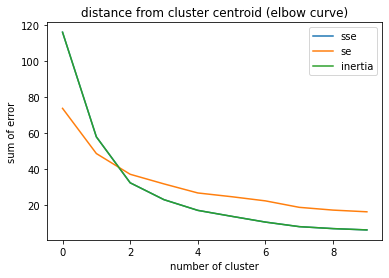

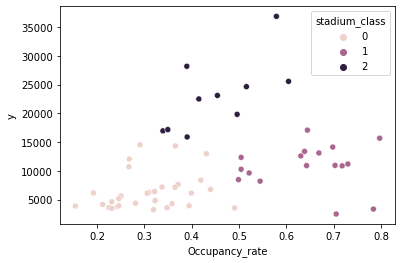

In [8]:
# スタジアムにおける観客数平均、満員率平均の２変数をクラスタリング(df_stadium_average)

# Kmeanをインポート
from sklearn.cluster import KMeans

df_stadium_average = df1.copy()
df_stadium_average['Occupancy_rate'] = df_stadium_average['Occupancy_rate'] = df_stadium_average['y'] / df_stadium_average['capa']
df_stadium_average = pd.pivot_table(df_stadium_average.query("year == 2012 or year == 2013"),
                                    index="stadium", 
                                    values=["y", 'Occupancy_rate'])

#正規化
from sklearn.preprocessing import StandardScaler

#分散正規化のインスタンスを作成
stdsc = StandardScaler()
#分散正規化を実行
stdsc.fit(df_stadium_average)
stdsc.transform(df_stadium_average)

max_cluster_num = 10
data_array_class_stadium_average = stdsc.transform(df_stadium_average)

# エルボー法で最適なクラスタ数を探索する
sse = np.zeros((max_cluster_num, ))     # Sum of Square Error（クラスタ内誤差平方和）
se = np.zeros((max_cluster_num, ))      # Sum of Error（クラスタ内誤差和）
inertia = np.zeros((max_cluster_num, )) # scikit-learnにより自動計算するクラスタ内誤差平方和
for i in range(max_cluster_num):
    cluster_num = i + 1
    kmeans = KMeans(n_clusters=cluster_num)
    # 各データがどのクラスタに所属するか
    pred = kmeans.fit_predict(data_array_class_stadium_average)
    inertia[i] = kmeans.inertia_
    
    # 各データが自身の所属するクラスタ中心からどれだけ離れているか調べる
    transforms = kmeans.transform(data_array_class_stadium_average)    
    distances = np.zeros((data_array_class_stadium_average.shape[0]))
    for index in range(len(transforms)):
        distances[index] = transforms[index, pred[index]]
    
    se[i] = np.sum(distances)
    sse[i] = np.sum(distances**2)

plt.title('distance from cluster centroid (elbow curve)')
plt.xlabel('number of cluster')
plt.ylabel('sum of error')
plt.plot(sse, label='sse')
plt.plot(se, label='se')
plt.plot(inertia, label='inertia')
plt.legend()
plt.show()

#クラスタ分析を実行 (クラスタ数=3)
n_clusters=3
pred_stadium = KMeans(n_clusters=3, random_state=0).fit_predict(data_array_class_stadium_average)
df_stadium_average["stadium_class"] = pred_stadium

#可視化
import seaborn as sns
sns.scatterplot(x="Occupancy_rate", y="y", hue="stadium_class", data=df_stadium_average)

df_stadium_average = df_stadium_average.reset_index()

#カラム変更
df_stadium_average = df_stadium_average.loc[:, ["stadium", "stadium_class"]]

#2012～2013のデータがない香川県立丸亀競技場を追加
df_stadium_average.loc[58] = [ '香川県立丸亀競技場', "0"]
df_stadium_average['stadium_class'] = df_stadium_average['stadium_class'].astype(np.int64)

In [9]:
# スタジアム別平均観客動員数(df1_studium_ave)
df1_studium_ave = df1.query("year == 2012 or year == 2013")
df1_studium_ave = pd.pivot_table(df1_studium_ave, index="stadium", values="y")
df1_studium_ave = df1_studium_ave.reset_index()
df1_studium_ave = df1_studium_ave.rename({"y":"stadium_average"}, axis=1)
df1_studium_ave.head()

,stadium,stadium_average
0,うまかな・よかなスタジアム,6167.289474
1,とりぎんバードスタジアム,3614.738095
2,エコパスタジアム,23119.000000
3,エディオンスタジアム広島,16964.852941
4,キンチョウスタジアム,13120.350000


In [10]:
#財務関係の特徴量を挿入(
df_finance = pd.read_csv('data/Jleague基礎データ.csv', encoding='ANSI')

year2012 = df1.query('year == 2012')
year2013 = df1.query('year == 2013')
year2014 = df1.query('year == 2014')

#前年度財務
df_finance2011 = df_finance[['name', '2011営業収入', '2011入場料', '2011スポンサー料', '2011人件費', '2012home', '2012away']]
df_finance2012 = df_finance[['name', '2012営業収入', '2012入場料', '2012スポンサー料', '2012人件費', '2013home', '2013away']]
df_finance2013 = df_finance[['name', '2013営業収入', '2013入場料', '2013スポンサー料', '2013人件費', '2014home', '2014away']]

#財務関係カラム名変更
df_finance2011= df_finance2011.rename(columns={'2011営業収入':'last_year_income', 
                                               '2011入場料':'last_year_entrancefee',
                                               '2011スポンサー料':'last_year_Sponsorfee',
                                               '2011人件費':'last_year_laborcost',
                                               '2012home':'home_avarage',
                                               '2012away':'away_avarage'})
df_finance2012 =df_finance2012.rename(columns={'2012営業収入':'last_year_income',
                                               '2012入場料':'last_year_entrancefee',
                                               '2012スポンサー料':'last_year_Sponsorfee',
                                               '2012人件費':'last_year_laborcost',
                                               '2013home':'home_avarage',
                                               '2013away':'away_avarage'})
df_finance2013 =df_finance2013.rename(columns={'2013営業収入':'last_year_income',
                                               '2013入場料':'last_year_entrancefee',
                                               '2013スポンサー料':'last_year_Sponsorfee',
                                               '2013人件費':'last_year_laborcost',
                                               '2014home':'home_avarage',
                                               '2014away':'away_avarage'})

#3パターンの年度データとその前年度財務データをマージ
year2012_finance = pd.merge(year2012, df_finance2011, left_on='home', right_on='name')
year2012_finance  = pd.merge(year2012_finance, df_finance2011, left_on='away', right_on='name')

year2013_finance = pd.merge(year2013,df_finance2012, left_on='home', right_on='name')
year2013_finance = pd.merge(year2013_finance, df_finance2012, left_on='away', right_on='name')

year2014_finance = pd.merge(year2014, df_finance2013, left_on='home', right_on='name')
year2014_finance = pd.merge(year2014_finance, df_finance2013, left_on='away', right_on='name')

#2012,2013,2014を縦に結合
df_finance_add = pd.concat([year2012_finance, year2013_finance, year2014_finance], axis=0)
#不要なカラム"name_x"と"name_y"を削除
df_finance_add = df_finance_add.drop(['name_x', 'name_y'], axis=1)
#カラム名変更
df_finance_add = (df_finance_add.rename({"last_year_income_x":"last_year_income_home",
                                         "last_year_entrancefee_x":"last_year_entrancefee_home",
                                         "last_year_Sponsorfee_x":"last_year_Sponsorfee_home",
                                         "last_year_laborcost_x":"last_year_laborcost_home",
                                         "home_avarage_x":"hometeam_home_avarage",
                                         "away_avarage_x":"hometeam_away_avarage",
                                         "last_year_income_y":"last_year_income_away",
                                         "last_year_entrancefee_y":"last_year_entrancefee_away",
                                         "last_year_Sponsorfee_y":"last_year_Sponsorfee_away",
                                         "last_year_laborcost_y":"last_year_laborcost_away",
                                         "home_avarage_y":"awayteam_home_avarage",
                                         "away_avarage_y":"awayteam_away_avarage"},
                                        axis=1))
df1 = df_finance_add
df1.head(1)

,id,y,year,stage,match,gameday,time,home,away,stadium,...,last_year_Sponsorfee_home,last_year_laborcost_home,hometeam_home_avarage,hometeam_away_avarage,last_year_income_away,last_year_entrancefee_away,last_year_Sponsorfee_away,last_year_laborcost_away,awayteam_home_avarage,awayteam_away_avarage
0,13994,18250,2012,Ｊ１,第１節第１日,03/10(土),14,ベガルタ仙台,鹿島アントラーズ,ユアテックスタジアム仙台,...,689.0,1007.0,16600.0,18390.0,4165.0,1839.0,754.0,2066.0,15381.0,19829.0


In [11]:
#df1と天気とクラスタリングととスタジアム別平均観客動員数をマージして、新たなdf1_mergeとする
df_stadium= pd.merge(df1, df1_studium_ave, on="stadium", how="outer")
df_weather = pd.merge(df_stadium, df1_weather, on="id")
df_stadium_class = pd.merge(df_weather, df_stadium_average, on="stadium")
df1_merge = df_stadium_class

In [12]:
#各特徴量を結合した上でdf1_mergeをLabelEncoder
from sklearn.preprocessing import LabelEncoder

df1_labelencode = df1_merge.copy()

for c in ['stage', 'home', 'away', 'stadium', 'weekday', "weather_y"]:
    le = LabelEncoder()
    le = le.fit(df1_labelencode[c])
    df1_labelencode[c] = le.transform(df1_labelencode[c])

df1_labelencode.head(1)

,id,y,year,stage,match,gameday,time,home,away,stadium,...,hometeam_away_avarage,last_year_income_away,last_year_entrancefee_away,last_year_Sponsorfee_away,last_year_laborcost_away,awayteam_home_avarage,awayteam_away_avarage,stadium_average,weather_y,stadium_class
0,13994,18250,2012,0,第１節第１日,03/10(土),14,15,37,15,...,18390.0,4165.0,1839.0,754.0,2066.0,15381.0,19829.0,15689.151515,7,1


In [13]:
# 不要になった変数を省く。(特徴量選択)
df2 = df1_labelencode.loc[:, ['id', 'y', 'year', 'home', 'stadium', 'capa', 'match_sec',
                              'month', 'weather_y', 'holiday', 'distance_away', 'stadium_class', 
                              'awayteam_away_avarage', 'hometeam_home_avarage', 'stadium_average',
                              'point_5game_average_away']]




# カラム名変更
df2 = df2.rename({"weather_y":"weather"}, axis=1)

In [14]:
# 満員率
df2['Occupancy_rate'] = df2['y'] / df2['capa']

# 訓練データ(～14年まで)とテストデータ(14年～)にわける。
#X_train, X_test, y_train, y_test にわける
X_train = df2.loc[df2['year'] != 2014].drop(['id', 'y', 'Occupancy_rate'], axis=1)
X_test = df2.loc[df2['year'] == 2014].drop(['id', 'y', 'Occupancy_rate'], axis=1)
y_train = df2['Occupancy_rate'].loc[df2['year'] != 2014]
y_test = df2['Occupancy_rate'].loc[df2['year'] == 2014]

In [15]:
# 訓練データとテストデータにわける。
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

In [16]:
print(X_train.shape)
print(X_val.shape)

(1382, 14)
(154, 14)


Training until validation scores don't improve for 15 rounds
[4]	train's l1: 0.141961	train's l2: 0.0292449	train's rmse: 0.171011	test's l1: 0.15103	test's l2: 0.032701	test's rmse: 0.180834
[8]	train's l1: 0.119457	train's l2: 0.0211136	train's rmse: 0.145305	test's l1: 0.128575	test's l2: 0.0246948	test's rmse: 0.157146
[12]	train's l1: 0.105476	train's l2: 0.0168727	train's rmse: 0.129895	test's l1: 0.114629	test's l2: 0.0205599	test's rmse: 0.143387
[16]	train's l1: 0.0967095	train's l2: 0.0143513	train's rmse: 0.119797	test's l1: 0.105898	test's l2: 0.0182616	test's rmse: 0.135135
[20]	train's l1: 0.0902499	train's l2: 0.0126994	train's rmse: 0.112692	test's l1: 0.0997593	test's l2: 0.0165442	test's rmse: 0.128624
[24]	train's l1: 0.0852231	train's l2: 0.0114816	train's rmse: 0.107152	test's l1: 0.0951393	test's l2: 0.015307	test's rmse: 0.123721
[28]	train's l1: 0.0815788	train's l2: 0.0105736	train's rmse: 0.102828	test's l1: 0.0914074	test's l2: 0.0143057	test's rmse: 0.119607

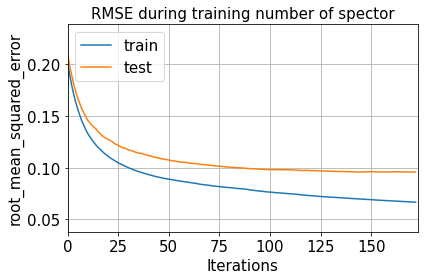

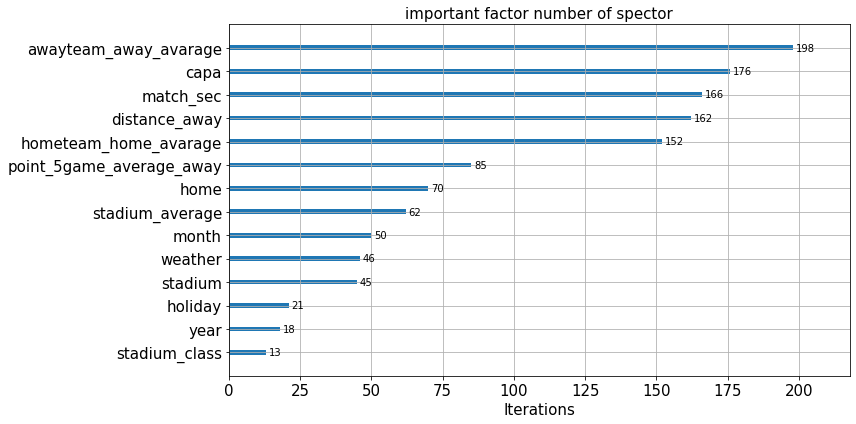

In [17]:
target_Yname = "number of spector"

# LightGBM用の変数にデータセット
lgbm_train = lgbm.Dataset(X_train, y_train)
lgbm_val = lgbm.Dataset(X_val, y_val, reference=lgbm_train)

my_params  = {
        'objective': 'regression',
        'learning_rate': 0.1, # 学習率
        'max_depth': -1, # 木の数 (負の値で無制限)
        'num_leaves': 9, # 枝葉の数
        'metric': ('mean_absolute_error', 'mean_squared_error', 'rmse'),
        #メトリック https://lightgbm.readthedocs.io/en/latest/Parameters.html#metric-parameters
        'drop_rate': 0.15,
        'verbose': 0
}

evaluation_results  = {}
# lgbm.trainが、scikit-learnのmodel.fitに相当する
regr = lgbm.train(my_params,
                      lgbm_train,
                      num_boost_round = 500, # 最大試行数
                      early_stopping_rounds=15, # この数分、連続でメトリックに変化なければ終了する
                      valid_sets = [lgbm_train, lgbm_val],
                      valid_names=['train', 'test'],
                      evals_result = evaluation_results,
                      verbose_eval = 4)
##### 以下、データ分析の可視化など
my_fontsize = 15

# 平均二乗偏差
ax = lgbm.plot_metric(evaluation_results, metric='rmse', ylabel='root_mean_squared_error')
my_x_label = ax.get_xlabel() # xラベルをゲット
my_y_label = ax.get_ylabel() # yラベルをゲット
ax.set_xlabel(my_x_label, fontsize=my_fontsize) # フォントサイズを指定して再セット
ax.set_ylabel(my_y_label, fontsize=my_fontsize) # フォントサイズを指定して再セット    
ax.set_title('RMSE during training ' + target_Yname, fontsize=my_fontsize) # フォントサイズを指定して再セット
ax.tick_params(labelsize=my_fontsize) # 目盛りのフォントサイズ
plt.legend(loc='upper left', fontsize=my_fontsize) # 凡例
plt.tight_layout()

# 重要因子のグラフ化
ax = lgbm.plot_importance(regr, max_num_features=50, figsize=(12, 6), 
                              xlabel='Feature value', ylabel='', title='important factor')

my_title = ax.get_title() # タイトルをゲット
ax.set_xlabel(my_x_label, fontsize=my_fontsize) # フォントサイズを指定して再セット
ax.set_title(my_title + ' ' + target_Yname, fontsize=my_fontsize) # フォントサイズを指定して再セット
ax.tick_params(labelsize=my_fontsize) # 目盛りのフォントサイズ
plt.tight_layout()

# 重要因子のテキスト出力
importance_df = pd.DataFrame(regr.feature_importance(), columns=['importance'])
sorted_importance_df = importance_df.sort_values(by='importance', ascending=False)
print(sorted_importance_df)
if sorted_importance_df.shape[0] > 5:
    important_factor = list(sorted_importance_df.index[:5])  
else:
    important_factor = list(sorted_importance_df)

# テストデータで回帰予測して、RMSE を出力
y_pred = regr.predict(X_test, num_iteration=regr.best_iteration)
mse = mean_squared_error(y_test*X_test['capa'], y_pred*X_test['capa'])
rmse = np.sqrt(mse)
print("rmse : {}".format(rmse))


# Appendix

### 5.2 作成したが使わなかった特徴量の実装コード

In [18]:
df_appendix = df1_merge.copy()

In [19]:
# 温度と気温から不快指数を計算
T = df_appendix["temperature"].astype('float')
H = df_appendix["humidity"].astype('float')
df_appendix["THI"] = 0.81*T + 0.01*H*(0.99*T - 14.3) + 46.3

In [20]:
# 各試合のhome勝ち点欄、away勝ち点欄挿入
# 勝利3点、引き分け1点、敗戦0点

home_points=[]
away_points=[]


for c in range(len(df_appendix.index)):
    if df_appendix.loc[c, 'away_score'] > df_appendix.loc[c, 'home_score']:
        home_points.append(0)
        away_points.append(3)

    elif df_appendix.loc[c, 'away_score'] == df_appendix.loc[c, 'home_score']:
        home_points.append(1)
        away_points.append(1)

    else:
        home_points.append(3)
        away_points.append(0)
    
    
df_appendix['points_home'] = pd.Series(home_points)
df_appendix['points_away'] = pd.Series(away_points)

In [21]:
# 直近3試合、直近5試合の勝ち点の平均の特徴量
# （ホームチームの直近3試合の平均、アウェイチームの直近3試合の平均、ホームチームの直近5試合の平均）

# ホームチームの直近3試合の勝ち点平均
point_3game_average_home = [\
               (
              # ホーム試合の勝ち点合計
            df_appendix.loc[(df_appendix['match_sec'] == df_appendix.loc[i, 'match_sec']-1) & (df_appendix['year'] == df_appendix.loc[i, 'year']) & (df_appendix['home'] == df_appendix.loc[c, 'home']), 'points_home'].sum()\
            +df_appendix.loc[(df_appendix['match_sec'] == df_appendix.loc[i, 'match_sec']-2) & (df_appendix['year'] == df_appendix.loc[i, 'year']) & (df_appendix['home'] == df_appendix.loc[c, 'home']), 'points_home'].sum()\
            +df_appendix.loc[(df_appendix['match_sec'] == df_appendix.loc[i, 'match_sec']-3) & (df_appendix['year'] == df_appendix.loc[i, 'year']) & (df_appendix['home'] == df_appendix.loc[c, 'home']), 'points_home'].sum()\
            +\
              # アウェイ試合の勝ち点合計
            df_appendix.loc[(df_appendix['match_sec'] == df_appendix.loc[i, 'match_sec']-1) & (df_appendix['year'] == df_appendix.loc[i, 'year']) & (df_appendix['away'] == df_appendix.loc[c, 'home']), 'points_away'].sum()\
            +df_appendix.loc[(df_appendix['match_sec'] == df_appendix.loc[i, 'match_sec']-2) & (df_appendix['year'] == df_appendix.loc[i, 'year']) & (df_appendix['away'] == df_appendix.loc[c, 'home']), 'points_away'].sum()\
            +df_appendix.loc[(df_appendix['match_sec'] == df_appendix.loc[i, 'match_sec']-3) & (df_appendix['year'] == df_appendix.loc[i, 'year']) & (df_appendix['away'] == df_appendix.loc[c, 'home']), 'points_away'].sum())\
                /3\
                for i in range(len(df_appendix.index))]# 全部の行で処理


# アウェイチームの直近3試合の勝ち点平均
point_3game_average_away = [\
               (
              # ホーム試合の勝ち点合計
            df_appendix.loc[(df_appendix['match_sec'] == df_appendix.loc[i, 'match_sec']-1) & (df_appendix['year'] == df_appendix.loc[i, 'year']) & (df_appendix['home'] == df_appendix.loc[c, 'away']), 'points_home'].sum()\
            +df_appendix.loc[(df_appendix['match_sec'] == df_appendix.loc[i, 'match_sec']-2) & (df_appendix['year'] == df_appendix.loc[i, 'year']) & (df_appendix['home'] == df_appendix.loc[c, 'away']), 'points_home'].sum()\
            +df_appendix.loc[(df_appendix['match_sec'] == df_appendix.loc[i, 'match_sec']-3) & (df_appendix['year'] == df_appendix.loc[i, 'year']) & (df_appendix['home'] == df_appendix.loc[c, 'away']), 'points_home'].sum()\
            +\
              # アウェイ試合の勝ち点合計
            df_appendix.loc[(df_appendix['match_sec'] == df_appendix.loc[i, 'match_sec']-1) & (df_appendix['year'] == df_appendix.loc[i, 'year']) & (df_appendix['away'] == df_appendix.loc[c, 'away']), 'points_away'].sum()\
            +df_appendix.loc[(df_appendix['match_sec'] == df_appendix.loc[i, 'match_sec']-2) & (df_appendix['year'] == df_appendix.loc[i, 'year']) & (df_appendix['away'] == df_appendix.loc[c, 'away']), 'points_away'].sum()\
            +df_appendix.loc[(df_appendix['match_sec'] == df_appendix.loc[i, 'match_sec']-3) & (df_appendix['year'] == df_appendix.loc[i, 'year']) & (df_appendix['away'] == df_appendix.loc[c, 'away']), 'points_away'].sum())\
                /3\
                for i in range(len(df_appendix.index))]# 全部の行で処理


df_appendix['point_3game_average_home'] = pd.Series(point_3game_average_home)
df_appendix['point_3game_average_away'] = pd.Series(point_3game_average_away)


# ホームチームの直近5試合の勝ち点平均
point_5game_average_home=[\
              # ホーム試合の勝ち点合計
               ( 
            df_appendix.loc[(df_appendix['match_sec'] == df_appendix.loc[i, 'match_sec']-1) & (df_appendix['year'] == df_appendix.loc[i, 'year']) & (df_appendix['home'] == df_appendix.loc[c, 'home']), 'points_home'].sum()\
            +df_appendix.loc[(df_appendix['match_sec'] == df_appendix.loc[i, 'match_sec']-2) & (df_appendix['year'] == df_appendix.loc[i, 'year']) & (df_appendix['home'] == df_appendix.loc[c, 'home']), 'points_home'].sum()\
            +df_appendix.loc[(df_appendix['match_sec'] == df_appendix.loc[i, 'match_sec']-3) & (df_appendix['year'] == df_appendix.loc[i, 'year']) & (df_appendix['home'] == df_appendix.loc[c, 'home']), 'points_home'].sum()\
            +df_appendix.loc[(df_appendix['match_sec'] == df_appendix.loc[i, 'match_sec']-4) & (df_appendix['year'] == df_appendix.loc[i, 'year']) & (df_appendix['home'] == df_appendix.loc[c, 'home']), 'points_home'].sum()\
            +df_appendix.loc[(df_appendix['match_sec'] == df_appendix.loc[i, 'match_sec']-5) & (df_appendix['year'] == df_appendix.loc[i, 'year']) & (df_appendix['home'] == df_appendix.loc[c, 'home']), 'points_home'].sum()\
            +\
              # アウェイ試合の勝ち点合計
            df_appendix.loc[(df_appendix['match_sec'] == df_appendix.loc[i, 'match_sec']-1) & (df_appendix['year'] == df_appendix.loc[i, 'year']) & (df_appendix['away'] == df_appendix.loc[c, 'home']), 'points_away'].sum()\
            +df_appendix.loc[(df_appendix['match_sec'] == df_appendix.loc[i, 'match_sec']-2) & (df_appendix['year'] == df_appendix.loc[i, 'year']) & (df_appendix['away'] == df_appendix.loc[c, 'home']), 'points_away'].sum()\
            +df_appendix.loc[(df_appendix['match_sec'] == df_appendix.loc[i, 'match_sec']-3) & (df_appendix['year'] == df_appendix.loc[i, 'year']) & (df_appendix['away'] == df_appendix.loc[c, 'home']), 'points_away'].sum()\
            +df_appendix.loc[(df_appendix['match_sec'] == df_appendix.loc[i, 'match_sec']-4) & (df_appendix['year'] == df_appendix.loc[i, 'year']) & (df_appendix['away'] == df_appendix.loc[c, 'home']), 'points_away'].sum()\
            +df_appendix.loc[(df_appendix['match_sec'] == df_appendix.loc[i, 'match_sec']-5) & (df_appendix['year'] == df_appendix.loc[i, 'year']) & (df_appendix['away'] == df_appendix.loc[c, 'home']), 'points_away'].sum())\
                /5\
                for i in range(len(df_appendix.index))]# 全部の行で処理


df_appendix['point_5game_average_home'] = pd.Series(point_5game_average_home)

In [22]:
# TVデータのグループ分け(df_tv_c)
# tvカラムの「/」で区切られている物をsplitで分け、データフレームに加えたdf_tvを作成
df_tv = pd.concat([df_appendix["id"], df_appendix['tv'].str.split('／', expand=True)], axis=1)

# 各変数をダミー化
df_appendix_tv_dammy = pd.get_dummies(df_tv, prefix='', prefix_sep='')
df_appendix_tv_dammy

# 転置してgroupbyで重複行をまとめ、再度転置してカラムに戻す
df_appendix_tv_dammy_T = df_appendix_tv_dammy.T
class_groupby = df_appendix_tv_dammy_T.groupby(level=0) 
df_tv_dammy2 = class_groupby.sum().T
df_tv_dammy2  = df_tv_dammy2.set_index('id')

# BS放送にグループ分け
df_bs = df_tv_dammy2['ＮＨＫ　ＢＳ１'] + df_tv_dammy2['ＮＨＫ　ＢＳ１（録）'] + df_tv_dammy2['ＢＳ－ＴＢＳ'] +df_tv_dammy2['ＢＳ－ＴＢＳ（録）']

# cs放送にグループ分け
df_cs  = (df_tv_dammy2['スカパー'] + df_tv_dammy2['スカパー光'] + df_tv_dammy2['スカパー光（スカイ・Ａ　ｓｐｏｒｔｓ＋）'] + 
         df_tv_dammy2['スカパー光（Ｊ　ＳＰＯＲＴＳ　１）'] + df_tv_dammy2['スカパー光（Ｊ　ＳＰＯＲＴＳ　４）'] +
         df_tv_dammy2['スカパー光（ＴＢＳチャンネル）'] + df_tv_dammy2['スカパー！'] + df_tv_dammy2['スカパー！プレミアムサービス']+
         df_tv_dammy2['スカパー！プレミアムサービス※１'] + df_tv_dammy2['ｅ２'] + df_tv_dammy2['ｅ２（スカイ・Ａ　ｓｐｏｒｔｓ＋）']+
         df_tv_dammy2['ｅ２（録）'])
# 地上波全国
df_digital = df_tv_dammy2["ＮＨＫ総合"]

# 地方局にグループ分け
df_local = (df_tv_dammy2['あいテレビ'] + df_tv_dammy2['とちぎテレビ'] + df_tv_dammy2['とちぎテレビ（録）']+df_tv_dammy2['テレビ信州']+
          df_tv_dammy2['テレビ大分'] + df_tv_dammy2['テレビ大阪'] + df_tv_dammy2['テレビ山梨'] + df_tv_dammy2['テレビ愛媛（録）'] + 
          df_tv_dammy2['テレビ新潟'] + df_tv_dammy2['テレビ神奈川'] + df_tv_dammy2['テレビ西日本（録）'] + df_tv_dammy2['テレビ静岡'] + 
          df_tv_dammy2['テレ玉'] + df_tv_dammy2['テレ玉（録）'] + df_tv_dammy2['ミヤギテレビ'] + df_tv_dammy2['中京テレビ（録）'] +
          df_tv_dammy2['中国放送'] + df_tv_dammy2['仙台放送'] + df_tv_dammy2['信越放送'] + df_tv_dammy2['北海道テレビ'] + 
          df_tv_dammy2['名古屋テレビ（録）'] +  df_tv_dammy2['富山テレビ'] + df_tv_dammy2['山形テレビ']+
          df_tv_dammy2['山梨放送'] + df_tv_dammy2['山陽放送'] + df_tv_dammy2['岐阜放送'] +  df_tv_dammy2['岐阜放送（録）'] +  
          df_tv_dammy2['岡山放送'] + df_tv_dammy2['岡山放送（録）'] + df_tv_dammy2['新潟テレビ２１'] +df_tv_dammy2['新潟放送'] +
          df_tv_dammy2['新潟総合テレビ'] + df_tv_dammy2['日本海テレビ'] + df_tv_dammy2['札幌テレビ'] + df_tv_dammy2['東北放送']+
          df_tv_dammy2['東海テレビ（録）']+df_tv_dammy2['毎日放送（録）'] + df_tv_dammy2['熊本放送'] + df_tv_dammy2['熊本県民テレビ'] +
          df_tv_dammy2['福岡放送（録）'] + df_tv_dammy2['群馬テレビ'] + df_tv_dammy2['群馬テレビ（録）'] + df_tv_dammy2['西日本放送'] +
          df_tv_dammy2['長崎国際テレビ'] + df_tv_dammy2['長野放送']  + df_tv_dammy2['長野朝日放送'] + df_tv_dammy2['静岡放送'] + 
          df_tv_dammy2['ＫＢＳ京都'] +df_tv_dammy2['ＫＢＳ京都（録）'] + df_tv_dammy2['ＮＨＫ京都'] + df_tv_dammy2['ＮＨＫ仙台'] + 
          df_tv_dammy2['ＮＨＫ佐賀'] + df_tv_dammy2['ＮＨＫ前橋'] +  df_tv_dammy2['ＮＨＫ北九州'] + df_tv_dammy2['ＮＨＫ名古屋'] + 
          df_tv_dammy2['ＮＨＫ大分'] + df_tv_dammy2['ＮＨＫ大阪'] + df_tv_dammy2['ＮＨＫ宇都宮'] + df_tv_dammy2['ＮＨＫ富山'] +  
          df_tv_dammy2['ＮＨＫ山形'] +  df_tv_dammy2['ＮＨＫ岐阜'] + df_tv_dammy2['ＮＨＫ岡山'] + df_tv_dammy2['ＮＨＫ広島'] + 
          df_tv_dammy2['ＮＨＫ徳島'] +df_tv_dammy2['ＮＨＫ徳島（録）'] + df_tv_dammy2['ＮＨＫ新潟'] + df_tv_dammy2['ＮＨＫ札幌'] +
          df_tv_dammy2['ＮＨＫ松山']+df_tv_dammy2['ＮＨＫ水戸'] + df_tv_dammy2['ＮＨＫ水戸（録）'] + df_tv_dammy2['ＮＨＫ熊本'] + 
          df_tv_dammy2['ＮＨＫ甲府'] +df_tv_dammy2['ＮＨＫ神戸'] + df_tv_dammy2['ＮＨＫ福岡'] + df_tv_dammy2['ＮＨＫ長崎']  + 
          df_tv_dammy2['ＮＨＫ長野'] + df_tv_dammy2['ＮＨＫ静岡'] + df_tv_dammy2['ＮＨＫ高松'] +df_tv_dammy2['ＮＨＫ鳥取'] + 
          df_tv_dammy2['ＴＯＫＹＯ　ＭＸ'] + df_tv_dammy2['ＴＯＫＹＯ　ＭＸ（録）'] )
# 4つのグループを結合
df3_tv = pd.concat([df_bs,df_cs, df_digital, df_local], axis=1)
df3_tv
# 4つのグループのカラム名付与(renameメソッドで連番で振られたものを書き換えるのほは不可能だった)
TVgroup = ["BS", "CS", "digital", "localTV"]
df3_tv.columns = TVgroup 
df_tv_c = df3_tv.reset_index()
df_tv_c.head()

,id,BS,CS,digital,localTV
0,13994,0,3,1,0
1,14012,0,3,0,0
2,14031,0,3,0,2
3,14055,1,3,0,0
4,14075,0,3,0,1


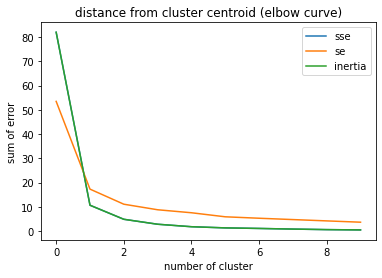

,away,away_class
0,アビスパ福岡,1
1,アルビレックス新潟,0
2,カターレ富山,1
3,ガイナーレ鳥取,1
4,ガンバ大阪,0


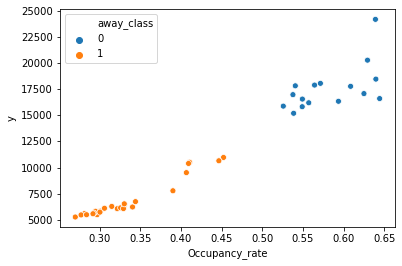

In [23]:
# アウェイチームにおける観客数平均、満員率平均の２変数(df_home_average)
df_away_average = df_appendix.copy()
df_away_average['Occupancy_rate'] = df_away_average['y'] / df_away_average['capa']
df_away_average =  pd.pivot_table(df_away_average.query("year == 2012 or year == 2013"),
                                  index = "away", 
                                  values = ["y", 'Occupancy_rate'])

# アウェイチームにおける観客数平均、満員率平均の２変数でクラスタリング
# 正規化
from sklearn.preprocessing import StandardScaler
# 分散正規化のインスタンスを作成
stdsc = StandardScaler()
# 分散正規化を実行
stdsc.fit(df_away_average)
stdsc.transform(df_away_average)
max_cluster_num = 10
data_array_class_away_average = stdsc.transform(df_away_average)

# エルボー法で最適なクラスタ数を探索する
sse = np.zeros((max_cluster_num, ))     # Sum of Square Error（クラスタ内誤差平方和）
se = np.zeros((max_cluster_num, ))      # Sum of Error（クラスタ内誤差和）
inertia = np.zeros((max_cluster_num, )) # scikit-learnにより自動計算するクラスタ内誤差平方和
for i in range(max_cluster_num):
    cluster_num = i + 1
    kmeans = KMeans(n_clusters=cluster_num)
    # 各データがどのクラスタに所属するか
    pred = kmeans.fit_predict(data_array_class_away_average)
    inertia[i] = kmeans.inertia_
    
    # 各データが自身の所属するクラスタ中心からどれだけ離れているか調べる
    transforms = kmeans.transform(data_array_class_away_average)    
    distances = np.zeros((data_array_class_away_average.shape[0]))
    for index in range(len(transforms)):
        distances[index] = transforms[index, pred[index]]
    
    se[i] = np.sum(distances)
    sse[i] = np.sum(distances**2)

plt.title('distance from cluster centroid (elbow curve)')
plt.xlabel('number of cluster')
plt.ylabel('sum of error')
plt.plot(sse, label='sse')
plt.plot(se, label='se')
plt.plot(inertia,label='inertia')
plt.legend()
plt.show()

# クラスタ分析を実行 (クラスタ数=2)
n_clusters = 2
pred_away = KMeans(n_clusters=2, random_state=0).fit_predict(data_array_class_away_average)
df_away_average["away_class"] = pred_away

# 可視化
import seaborn as sns
sns.scatterplot(x="Occupancy_rate", y="y", hue="away_class", data=df_away_average)

df_away_average = df_away_average.reset_index()

# カラム変更
df_away_average = df_away_average.loc[:, ["away", "away_class"]]
# 2012～2013のデータがないカマタマーレ讃岐を追加
df_away_average.loc[41] = [ 'カマタマーレ讃岐', "0"]
df_away_average['away_class'] = df_away_average['away_class'].astype(np.int64)
df_away_average.head()

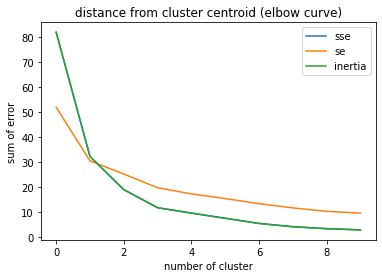

,home,home_class
0,アビスパ福岡,1
1,アルビレックス新潟,0
2,カターレ富山,1
3,ガイナーレ鳥取,1
4,ガンバ大阪,2


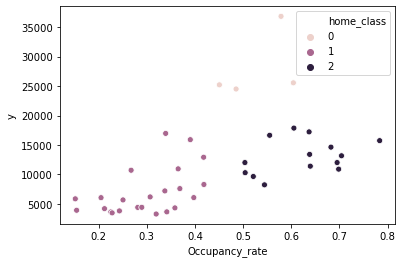

In [24]:
# ホームチームにおける観客数平均、満員率平均の２変数(df_home_average)
df_home_average = df_appendix.copy()
df_home_average['Occupancy_rate'] = df_home_average['Occupancy_rate'] = df_home_average['y'] / df_home_average['capa']
df_home_average =  pd.pivot_table(df_home_average.query("year == 2012 or year == 2013"),
                                  index = "home",
                                  values = ["y", 'Occupancy_rate'])
# ホームチームにおける観客数平均、満員率平均の２変数でクラスタリング
# 正規化
from sklearn.preprocessing import StandardScaler
# 分散正規化のインスタンスを作成
stdsc = StandardScaler()
# 分散正規化を実行
stdsc.fit(df_home_average)
stdsc.transform(df_home_average)

max_cluster_num = 10

data_array_class_home_average = stdsc.transform(df_home_average)

# エルボー法で最適なクラスタ数を探索する
sse = np.zeros((max_cluster_num, ))     # Sum of Square Error（クラスタ内誤差平方和）
se = np.zeros((max_cluster_num, ))      # Sum of Error（クラスタ内誤差和）
inertia = np.zeros((max_cluster_num, )) # scikit-learnにより自動計算するクラスタ内誤差平方和
for i in range(max_cluster_num):
    cluster_num = i + 1
    kmeans = KMeans(n_clusters=cluster_num)
    # 各データがどのクラスタに所属するか
    pred = kmeans.fit_predict(data_array_class_home_average)
    inertia[i] = kmeans.inertia_
    
    # 各データが自身の所属するクラスタ中心からどれだけ離れているか調べる
    transforms = kmeans.transform(data_array_class_home_average)    
    distances = np.zeros((data_array_class_home_average.shape[0]))
    for index in range(len(transforms)):
        distances[index] = transforms[index, pred[index]]
    
    se[i] = np.sum(distances)
    sse[i] = np.sum(distances**2)

plt.title('distance from cluster centroid (elbow curve)')
plt.xlabel('number of cluster')
plt.ylabel('sum of error')
plt.plot(sse, label='sse')
plt.plot(se, label='se')
plt.plot(inertia, label='inertia')
plt.legend()
plt.show()

# クラスタ分析を実行 (クラスタ数=3)
n_clusters = 3
pred_home = KMeans(n_clusters=3, random_state=0).fit_predict(data_array_class_home_average)
df_home_average["home_class"] = pred_home

# 可視化
import seaborn as sns
sns.scatterplot(x="Occupancy_rate", y="y", hue="home_class", data=df_home_average)

df_home_average = df_home_average.reset_index()

# カラム変更
df_home_average = df_home_average.loc[:, ["home", "home_class"]]
# 2012～2013のデータがないカマタマーレ讃岐を追加
df_home_average.loc[41] = [ 'カマタマーレ讃岐', "0"]
df_home_average['home_class'] = df_home_average['home_class'].astype(np.int64)
df_home_average.head()

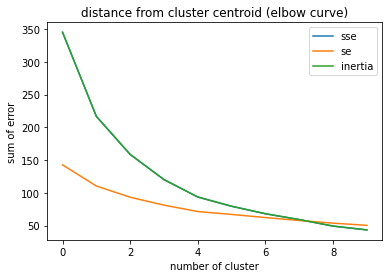

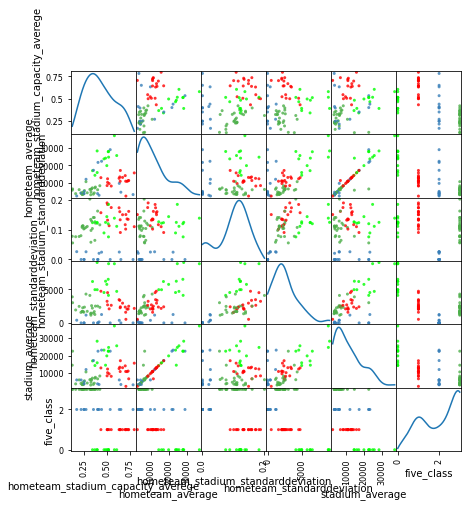

,home,stadium,five_class
0,アビスパ福岡,レベルファイブスタジアム,3
1,アルビレックス新潟,デンカビッグスワンスタジアム,0
2,カターレ富山,富山県総合運動公園陸上競技場,3
3,ガイナーレ鳥取,とりぎんバードスタジアム,3
4,ガンバ大阪,万博記念競技場,1


In [25]:
"""2012年～2013年各チームがホームの試合の動員数の平均と標準偏差と、満員率の平均と標準偏差の４変数と、スタジアム容量の平均の合計５変数を
クラスタリングした際のクラスタ番号を特徴量化(df1_5variable)"""

df["stadium_per_capacity"] = df["y"] / df["capa"]
# ホームの試合の動員数平均と満員率の平均と標準偏差を表示
df_home_ave_std = pd.pivot_table(df.query("year == 2012 or year == 2013"), 
                                 index = ["home", "stadium"],
                                 values = ["y", "stadium_per_capacity"],
                                aggfunc = [np.mean, np.std]).reset_index()

df_home_ave_std.columns = ["home", "stadium",
                           "hometeam_stadium_capacity_averege", 
                           "hometeam_average",
                           "hometeam_stadium_standarddeviation",
                           "hometeam_standarddeviation"]

# スタジアム容量の平均
df1_studium_average = pd.pivot_table(df1.query("year == 2012 or year == 2013"),
                                     index=["stadium"],
                                     values="y").reset_index()
df1_studium_average.columns = ["stadium", "stadium_average"]

# マージ
df_merge_5variable_class = pd.merge(df_home_ave_std, df1_studium_average, on="stadium")
df_merge_5variable_class = df_merge_5variable_class.set_index(["home", "stadium"])
# 欠損値0埋め（データが一つしかないので標準偏差がない）
df_merge_5variable_class = df_merge_5variable_class.fillna(0)
df_merge_5variable_class

# 正規化
from sklearn.preprocessing import StandardScaler
# 分散正規化のインスタンスを作成
stdsc = StandardScaler()
# 分散正規化を実行
stdsc.fit(df_merge_5variable_class)
stdsc.transform(df_merge_5variable_class)

# Kmeanをインポート
from sklearn.cluster import KMeans

max_cluster_num = 10

data_array_5variable_class = stdsc.transform(df_merge_5variable_class)

# エルボー法で最適なクラスタ数を探索する
sse = np.zeros((max_cluster_num, ))     # Sum of Square Error（クラスタ内誤差平方和）
se = np.zeros((max_cluster_num, ))      # Sum of Error（クラスタ内誤差和）
inertia = np.zeros((max_cluster_num, )) # scikit-learnにより自動計算するクラスタ内誤差平方和
for i in range(max_cluster_num):
    cluster_num = i + 1
    kmeans = KMeans(n_clusters=cluster_num)
    # 各データがどのクラスタに所属するか
    pred = kmeans.fit_predict(data_array_5variable_class)
    inertia[i] = kmeans.inertia_
    
    # 各データが自身の所属するクラスタ中心からどれだけ離れているか調べる
    transforms = kmeans.transform(data_array_5variable_class)    
    distances = np.zeros((data_array_5variable_class.shape[0]))
    for index in range(len(transforms)):
        distances[index] = transforms[index, pred[index]]
    
    se[i] = np.sum(distances)
    sse[i] = np.sum(distances**2)

plt.title('distance from cluster centroid (elbow curve)')
plt.xlabel('number of cluster')
plt.ylabel('sum of error')
plt.plot(sse, label='sse')
plt.plot(se, label='se')
plt.plot(inertia, label='inertia')
plt.legend()
plt.show()

# クラスタ分析を実行 (クラスタ数=4)
n_clusters = 4
pred = KMeans(n_clusters=4, random_state=0).fit_predict(data_array_5variable_class)
df_merge_5variable_class["five_class"] = pred

#クラスタリングの可視化
%matplotlib inline
from pandas import plotting # 高度なプロットを行うツールのインポート

# それぞれに与える色を決める。
color_codes = {0:'#00FF00', 1:'#FF0000', 2:'#377eb8', 3:'#4daf4a'}
# サンプル毎に色を与える。
colors = [color_codes[x] for x in pred]
# 色分けした Scatter Matrix を描く。
plotting.scatter_matrix(df_merge_5variable_class, figsize=(7, 7), 
                        color=colors, alpha=0.8, diagonal='kde')   #データのプロット
plt.show()

#i dとクラスタのみのデータフレーム化
df1_5variable_class_drop = df_merge_5variable_class.drop(["hometeam_stadium_capacity_averege", 
                                                          "hometeam_average",
                                                          "hometeam_stadium_standarddeviation",
                                                          "hometeam_standarddeviation",
                                                          "stadium_average"], 
                                                         axis=1)
df1_5variable = df1_5variable_class_drop.reset_index()
df1_5variable.head()

In [26]:
# 対戦カード別の平均観客数(df_match_ave)
df_match_ave = df1.query("year == 2012 or year == 2013")
df_match_ave = pd.pivot_table(df_match_ave, index=["home", "away"], values="y")
df_match_ave = df_match_ave.reset_index()
df_match_ave = df_match_ave.rename({"y":"match_average"}, axis=1)
df_match_ave.head()

,home,away,match_average
0,アビスパ福岡,カターレ富山,3625.0
1,アビスパ福岡,ガイナーレ鳥取,4475.0
2,アビスパ福岡,ガンバ大阪,14526.0
3,アビスパ福岡,ギラヴァンツ北九州,7338.5
4,アビスパ福岡,コンサドーレ札幌,5188.0


In [27]:
# df_appendixに各変数マージ(df_appendix_merge)

df_appendix_tv = pd.merge(df_appendix, df_tv_c, on="id")
df_appendix_away_average = pd.merge(df_appendix_tv, df_away_average, on="away")
df_appendix_home_average = pd.merge(df_appendix_away_average, df_home_average, on="home")
df_appendix_5variable = pd.merge(df_appendix_home_average, df1_5variable, on=["home", "stadium"], how='left')
df_appendix_match_ave = pd.merge(df_appendix_5variable, df_match_ave, on=["home", "away"], how='left')

df_appendix_merge = df_appendix_match_ave.copy()

In [28]:
# 各特徴量を結合した上でdf_appendix_mergeをLabelEncoder(df_appendix_merge)
from sklearn.preprocessing import LabelEncoder

for c in ['stage', 'home', 'away', 'stadium', 'weekday', "weather_y"]:
    le = LabelEncoder()
    le = le.fit(df_appendix_merge[c])
    df_appendix_merge[c] = le.transform(df_appendix_merge[c])

df_appendix_merge.head(1)

,id,y,year,stage,match,gameday,time,home,away,stadium,...,point_3game_average_away,point_5game_average_home,BS,CS,digital,localTV,away_class,home_class,five_class,match_average
0,13994,18250,2012,0,第１節第１日,03/10(土),14,15,37,15,...,0.0,0.0,0,3,1,0,0,2,1.0,18071.0


In [29]:
# 不要になった変数を省く
df_appendix_2 = df_appendix_merge.drop(['match', 'gameday', 'tv', 'home_score', 'away_score', 'weather_x'], axis=1)
# カラム名変更
df_appendix_2 = df_appendix_2.rename({"weather_y":"weather"}, axis=1)

In [30]:
# 満員率
df_appendix_2['Occupancy_rate'] = df_appendix_2['y'] / df_appendix_2['capa']

# 訓練データ(～14年まで)とテストデータ(14年～)にわける
#X_train, X_test, y_train, y_test にわける
X_train = df_appendix_2.loc[df_appendix_2['year'] != 2014].drop(['id', 'y', 'Occupancy_rate'], axis=1)
X_test = df_appendix_2.loc[df_appendix_2['year'] == 2014].drop(['id', 'y', 'Occupancy_rate'], axis=1)
y_train = df_appendix_2['Occupancy_rate'].loc[df_appendix_2['year'] != 2014]
y_test = df_appendix_2['Occupancy_rate'].loc[df_appendix_2['year'] == 2014]

In [31]:
# 訓練データとテストデータにわける。
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

Training until validation scores don't improve for 15 rounds
[4]	train's l1: 0.132363	train's l2: 0.0256763	train's rmse: 0.160238	test's l1: 0.146562	test's l2: 0.0295145	test's rmse: 0.171798
[8]	train's l1: 0.102534	train's l2: 0.0159359	train's rmse: 0.126237	test's l1: 0.113157	test's l2: 0.0180402	test's rmse: 0.134314
[12]	train's l1: 0.0836564	train's l2: 0.0109523	train's rmse: 0.104653	test's l1: 0.091277	test's l2: 0.0122426	test's rmse: 0.110646
[16]	train's l1: 0.0702535	train's l2: 0.00819521	train's rmse: 0.0905274	test's l1: 0.0763812	test's l2: 0.0090192	test's rmse: 0.0949695
[20]	train's l1: 0.0618709	train's l2: 0.00666813	train's rmse: 0.0816586	test's l1: 0.0674667	test's l2: 0.00728993	test's rmse: 0.0853811
[24]	train's l1: 0.0559808	train's l2: 0.00574032	train's rmse: 0.0757649	test's l1: 0.0616768	test's l2: 0.00636408	test's rmse: 0.0797752
[28]	train's l1: 0.0520436	train's l2: 0.00508978	train's rmse: 0.0713427	test's l1: 0.0581732	test's l2: 0.00584032	te

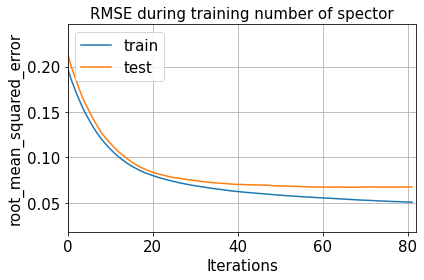

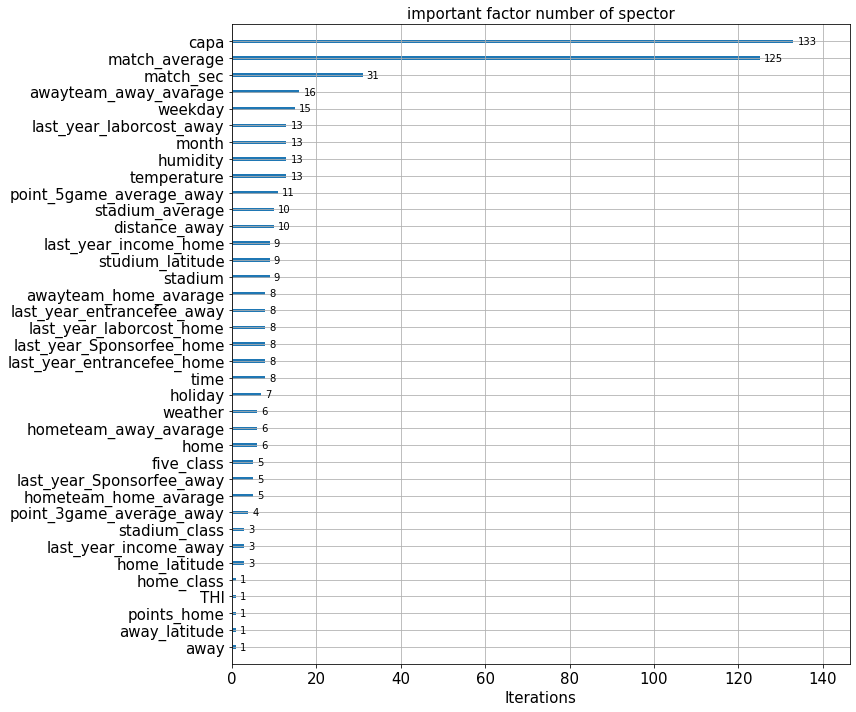

In [32]:
## 作成した特徴量を全て使用してモデルを作成

target_Yname = "number of spector"

# LightGBM用の変数にデータセット
lgbm_train = lgbm.Dataset(X_train, y_train)
lgbm_val = lgbm.Dataset(X_val, y_val, reference=lgbm_train)

my_params  = {
        'objective': 'regression',
        'learning_rate': 0.1, # 学習率
        'max_depth': -1, # 木の数 (負の値で無制限)
        'num_leaves': 9, # 枝葉の数
        'metric': ('mean_absolute_error', 'mean_squared_error', 'rmse'),
        #メトリック https://lightgbm.readthedocs.io/en/latest/Parameters.html#metric-parameters
        'drop_rate': 0.15,
        'verbose': 0
}

evaluation_results  = {}
# lgbm.trainが、scikit-learnのmodel.fitに相当する
regr = lgbm.train(my_params,
                      lgbm_train,
                      num_boost_round = 500, # 最大試行数
                      early_stopping_rounds= 15, # この数分、連続でメトリックに変化なければ終了する
                      valid_sets = [lgbm_train, lgbm_val],
                      valid_names = ['train', 'test'],
                      evals_result = evaluation_results,
                      verbose_eval = 4)
##### 以下、データ分析の可視化など
my_fontsize = 15

# 平均二乗偏差
ax = lgbm.plot_metric(evaluation_results, metric='rmse', ylabel='root_mean_squared_error')
my_x_label = ax.get_xlabel() # xラベルをゲット
my_y_label = ax.get_ylabel() # yラベルをゲット
ax.set_xlabel(my_x_label, fontsize=my_fontsize) # フォントサイズを指定して再セット
ax.set_ylabel(my_y_label, fontsize=my_fontsize) # フォントサイズを指定して再セット    
ax.set_title('RMSE during training ' + target_Yname, fontsize=my_fontsize) # フォントサイズを指定して再セット
ax.tick_params(labelsize=my_fontsize) # 目盛りのフォントサイズ
plt.legend(loc='upper left', fontsize=my_fontsize) # 凡例
plt.tight_layout()

# 重要因子のグラフ化
ax = lgbm.plot_importance(regr, max_num_features=50, figsize=(12, 10), 
                              xlabel='Feature value', ylabel='', title='important factor')

my_title = ax.get_title() # タイトルをゲット
ax.set_xlabel(my_x_label, fontsize=my_fontsize) # フォントサイズを指定して再セット
ax.set_title(my_title + ' ' + target_Yname, fontsize=my_fontsize) # フォントサイズを指定して再セット
ax.tick_params(labelsize=my_fontsize) # 目盛りのフォントサイズ
plt.tight_layout()

# 重要因子のテキスト出力
importance_df = pd.DataFrame(regr.feature_importance(), columns=['importance'])
sorted_importance_df = importance_df.sort_values(by='importance', ascending=False)
print(sorted_importance_df)
if sorted_importance_df.shape[0] > 5:
    important_factor = list(sorted_importance_df.index[:5])  
else:
    important_factor = list(sorted_importance_df)

# テストデータで回帰予測して、RMSE を出力
y_pred = regr.predict(X_test, num_iteration=regr.best_iteration)
mse = mean_squared_error(y_test*X_test['capa'], y_pred*X_test['capa'])
rmse = np.sqrt(mse)
print("rmse : {}".format(rmse))
